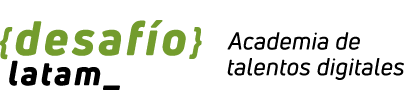

## <font color='green'>Ejercicio guiado</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('CarPrice_Assignment.xlsx')
print(data.shape)
data.head()

(205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### <font color='green'>Calidad de datos</font>

In [3]:
def data_quality_analysis(df):
    # Crear un nuevo dataframe para almacenar los resultados
    result_df = pd.DataFrame(columns=['Columna', 'Tipo de dato', 'Valores únicos', 'Valores faltantes'])

    # Obtener información general del dataframe
    columns = df.columns
    data_types = df.dtypes.to_list()
    unique_values = [df[column].nunique() for column in columns]
    missing_values = [df[column].isnull().sum() for column in columns]

    # Llenar el nuevo dataframe con los resultados
    result_df['Columna'] = columns
    result_df['Tipo de dato'] = data_types
    result_df['Valores únicos'] = unique_values
    result_df['Valores faltantes'] = missing_values

    return result_df

# Ejemplo de uso de la función con el dataframe 'df'
analysis_result = data_quality_analysis(data).set_index('Columna')
print(analysis_result.sort_values('Tipo de dato'))

                 Tipo de dato  Valores únicos  Valores faltantes
Columna                                                         
car_ID                  int64             205                  0
symboling               int64               6                  0
citympg                 int64              29                  0
peakrpm                 int64              23                  0
horsepower              int64              59                  0
enginesize              int64              44                  0
curbweight              int64             171                  0
highwaympg              int64              30                  0
compressionratio      float64              32                  0
stroke                float64              37                  0
boreratio             float64              38                  0
carheight             float64              49                  0
carlength             float64              75                  0
wheelbase             flo

In [3]:
data = data.drop(['car_ID', 'CarName'], axis=1)

### <font color='green'>Análisis exploratorio</font>

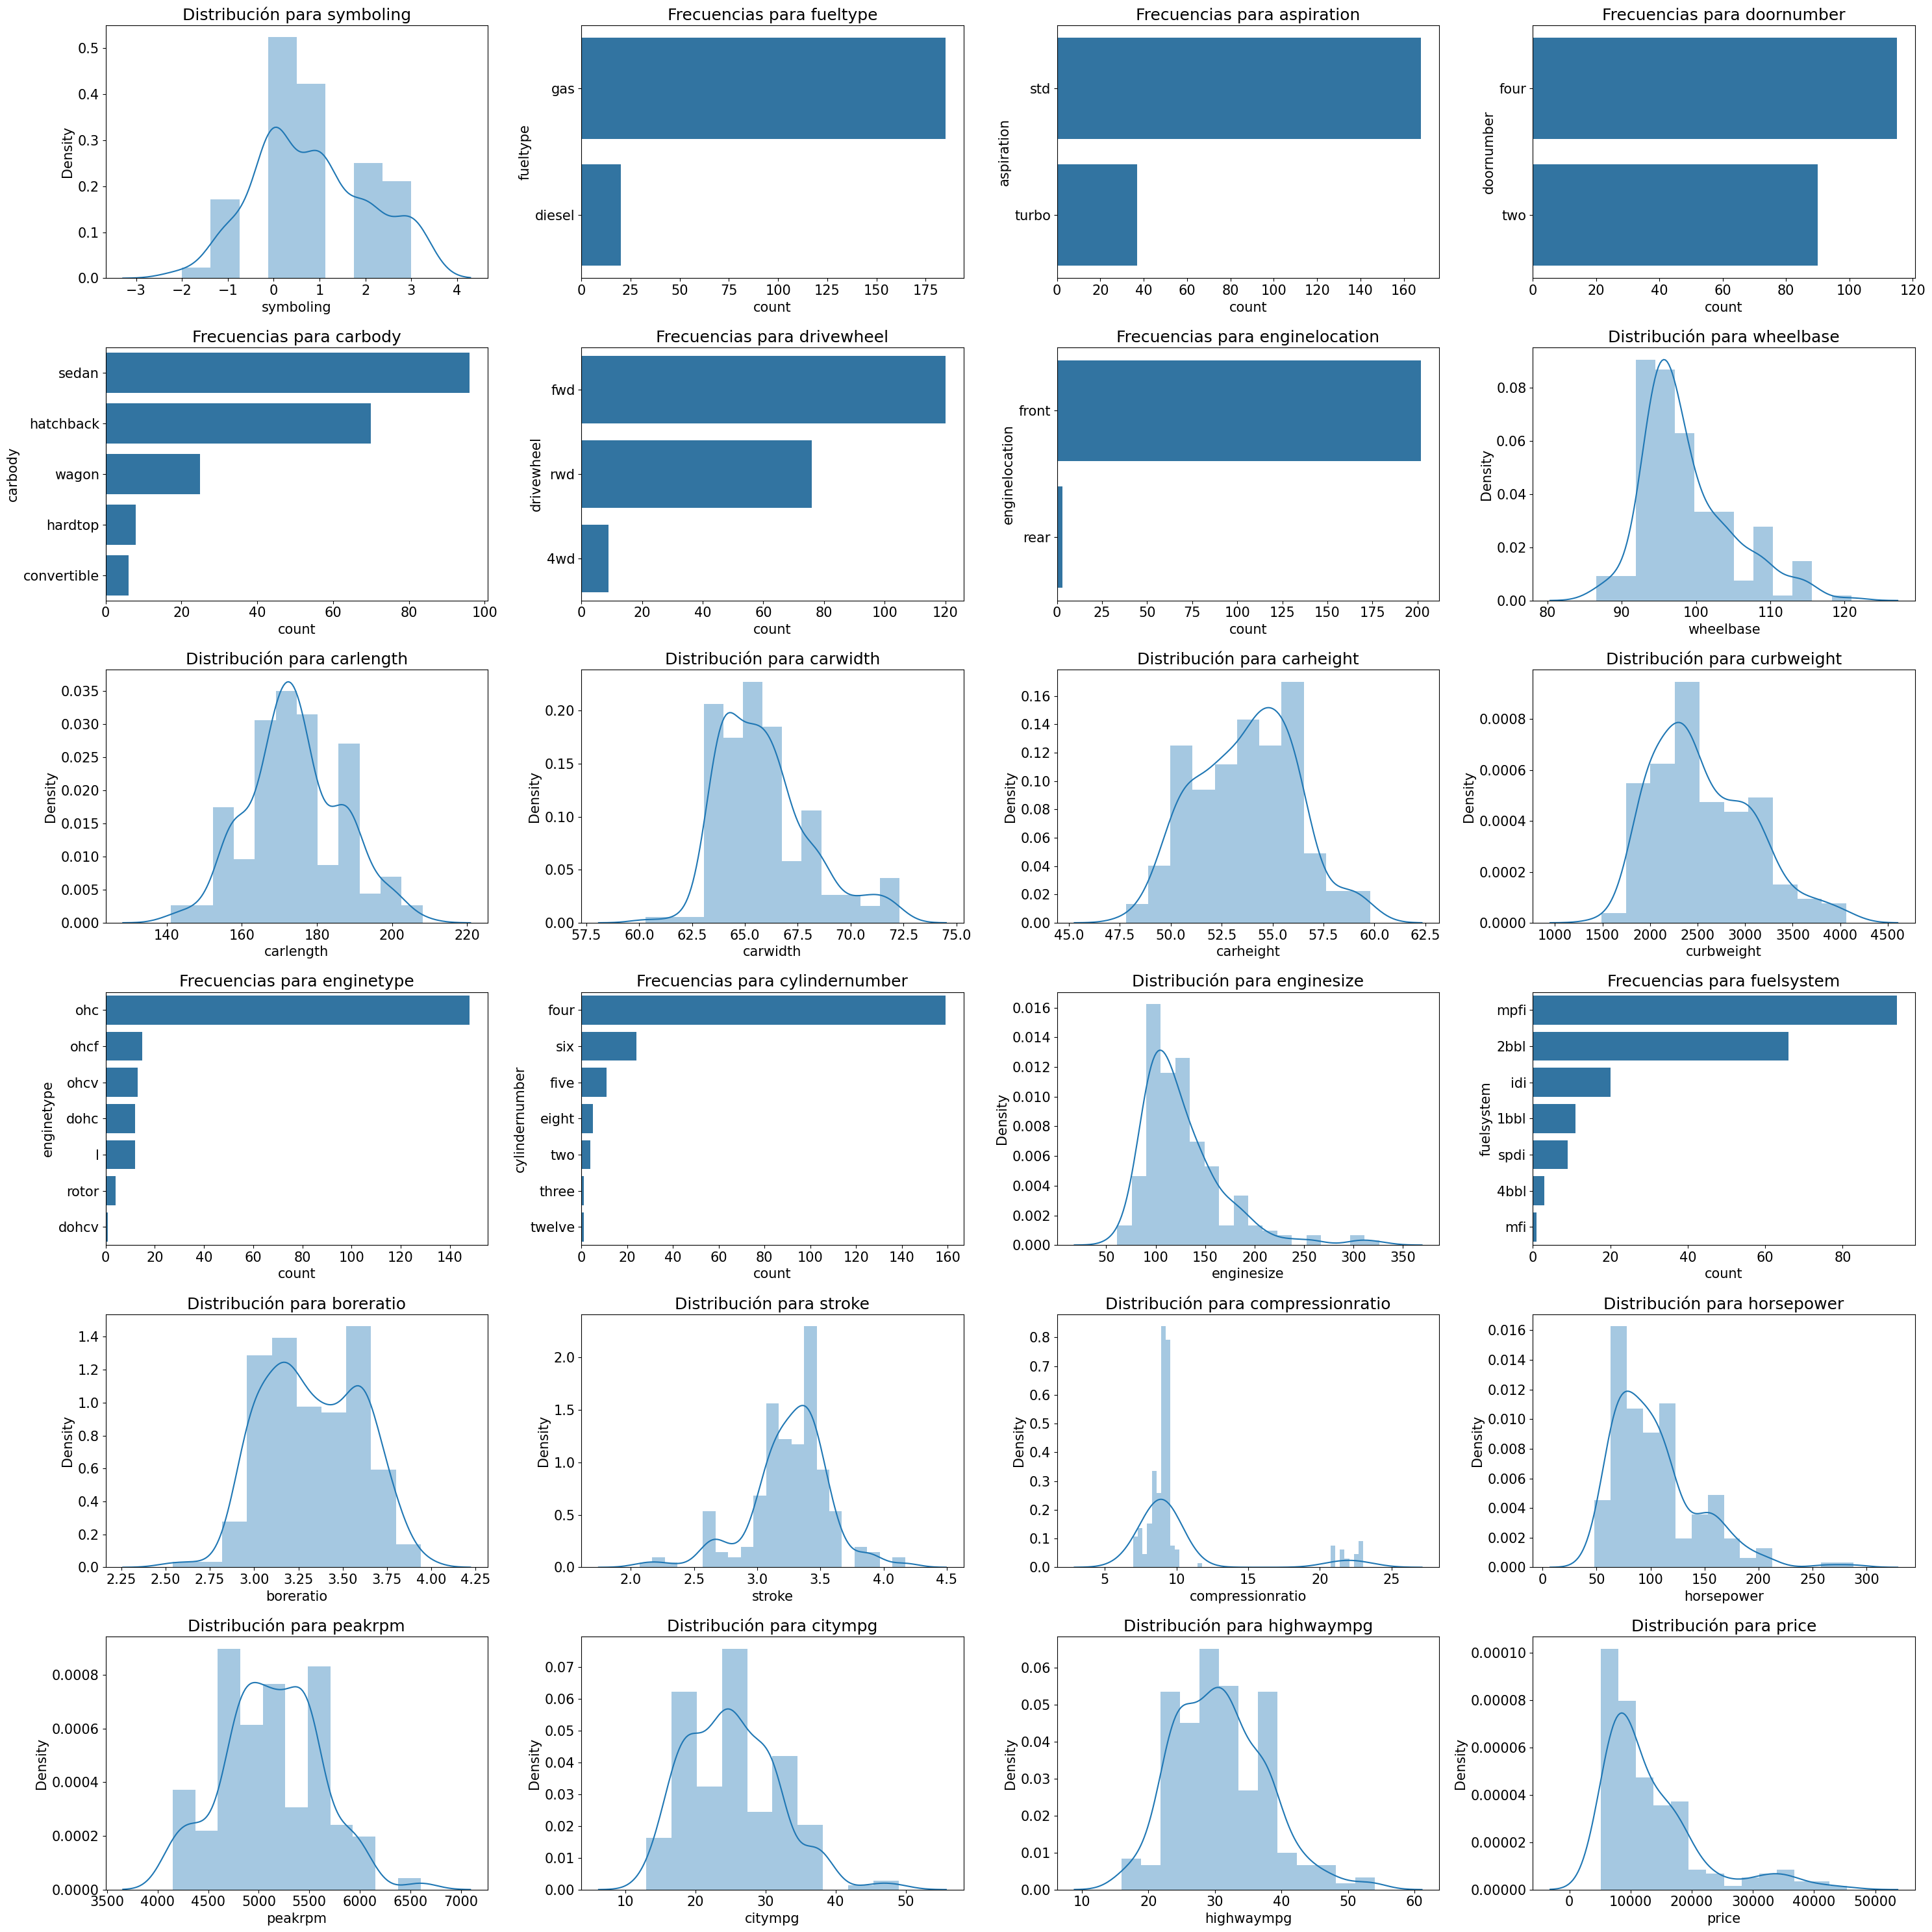

In [5]:
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(30, 30))
for n, i in enumerate(list(data.columns)):
    plt.subplot(6, 4, n + 1)
    if analysis_result.loc[i, 'Tipo de dato']=='object':
        sns.countplot(y= data[i], order=data[i].value_counts().iloc[:7].index)
        plt.title('Frecuencias para {}'.format(i))

    else:
        sns.distplot(data[i])
        plt.title('Distribución para {}'.format(i))
    plt.tight_layout()

Generaremos ahora un clustermap que muestra visualmente la correlación entre las variables numéricas especificadas en la lista numeric_values del DataFrame data. El clustermap utiliza una paleta de colores rojos para resaltar las relaciones de correlación entre las variables, y también muestra los valores numéricos de correlación en las celdas del mapa para facilitar la interpretación.

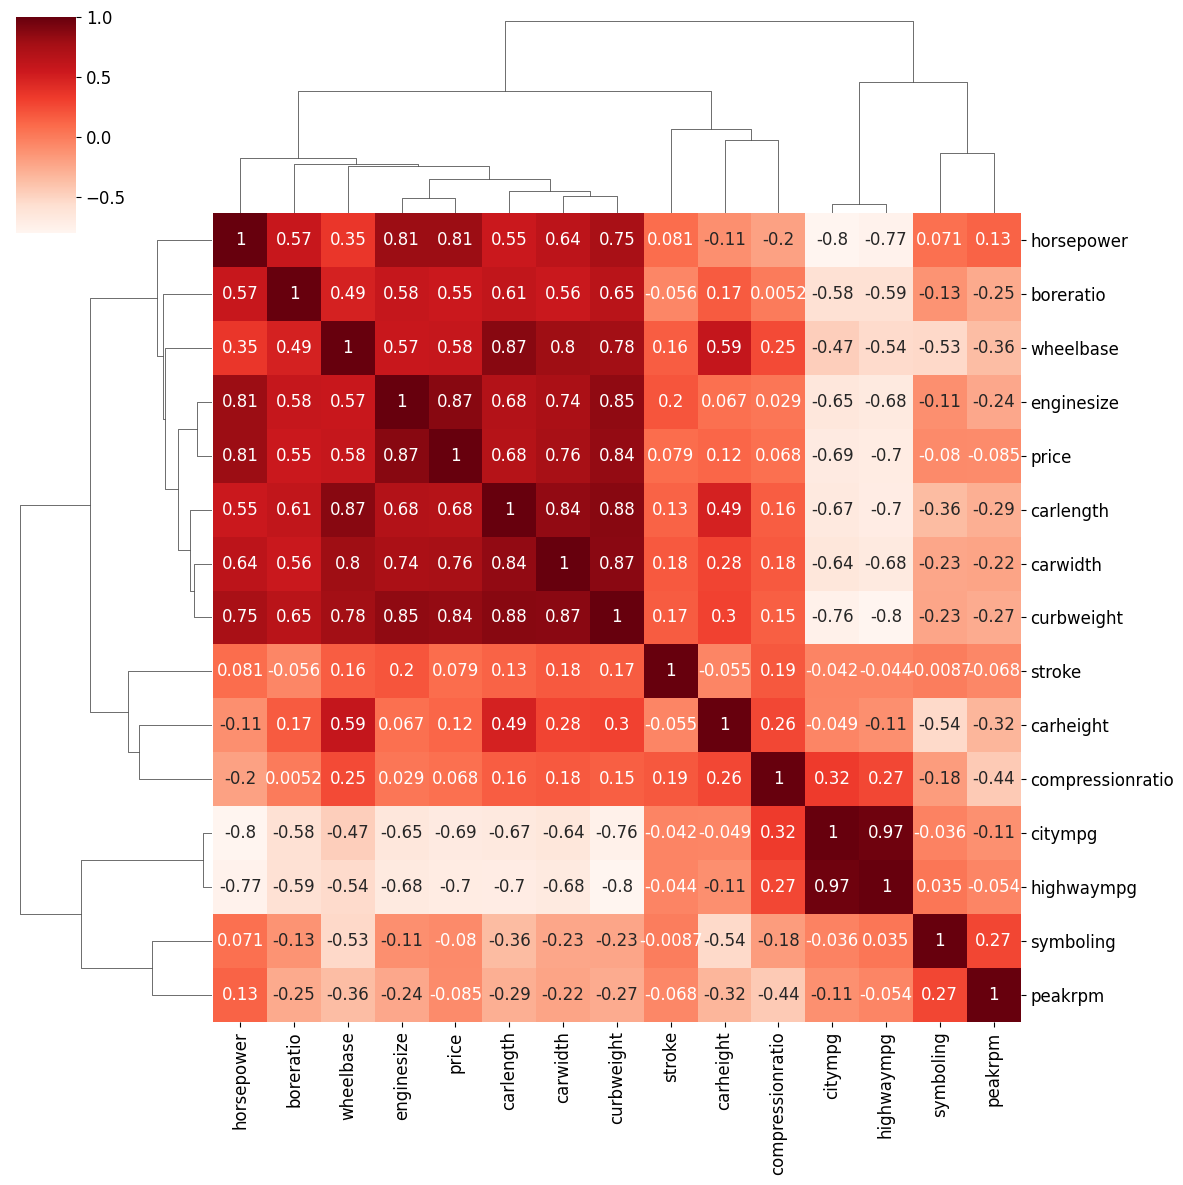

In [4]:
plt.rcParams.update({'font.size': 12})

numeric_values = ['symboling',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'enginesize',
 'boreratio',
 'stroke',
 'compressionratio',
 'horsepower',
 'peakrpm',
 'citympg',
 'highwaympg',
 'price']

sns.clustermap(data.loc[:, numeric_values].corr(), cmap='Reds', annot=True, figsize=(12, 12))

Así como las correlaciones entre todas las variables son importantes, las más relevantes son aquellas que podemos establecer con la variable objetivo para entender cuales son aquellas variables candidatas para ser mejores predictores.

<Axes: >

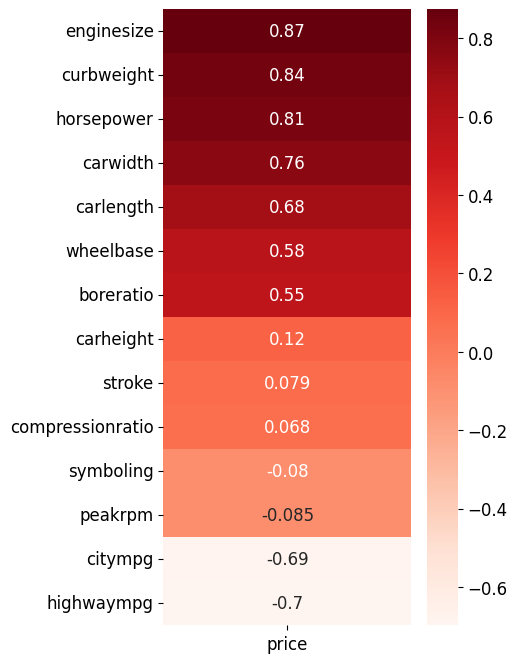

In [5]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(4, 8))
sns.heatmap(data.loc[:, numeric_values].corr().loc[:, ['price']].sort_values('price', ascending=False).iloc[1:], cmap='Reds', annot=True)


En este caso se observa una fuerte correlación directa entre “enginesize”, “curbweight” y el precio del auto, por los principales candidatos como variables. También se observa una fuerte correlación negativa con el precio en las variables “highwaympg” y “citympg”.

### <font color='green'>Transformación de variables</font>

In [6]:
# División del conjunto de datos en conjuntos de entrenamiento y prueba
X = pd.get_dummies(data).drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### <font color='green'>Entrenamiento del modelo</font>

In [7]:
def find_best_model(X, y):
    # Definir los hiperparámetros a ajustar para cada algoritmo
    lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
    ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
    
    elastic_params = {'alpha': [0.001, 0.01, 0.1, 1, 10],
                      'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
    
    tree_params = {'max_depth': [None, 10, 20, 30],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4]}

    # Definir los modelos
    lasso = Lasso()
    ridge = Ridge()
    elastic = ElasticNet()
    tree = DecisionTreeRegressor()

    # Realizar la búsqueda de hiperparámetros utilizando validación cruzada
    models = [lasso, ridge, elastic, tree]
    params = [lasso_params, ridge_params, elastic_params, tree_params]
    best_model = None
    best_params = None
    best_score = float('-inf')

    models_save = []

    for model, param_grid in zip(models, params):
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X, y)

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_model = model
            best_params = grid_search.best_params_
        print("Best Model: ", grid_search.best_estimator_)
        print("Best params: ", grid_search.best_params_)
        print("Ajuste: ", -grid_search.best_score_)
        print('-'*100)
        models_save.append(grid_search.best_estimator_)

    return best_model, best_params, models_save





La  función anterior toma como input las variables predictoras “X” y la variable objetivo “y”. Luego prueba los diferentes modelos vistos en clase y con el método de búsqueda de grilla busca los mejores hiper parámetros del modelo. Luego muestra cuál fue el mejor modelo y entrega el mejor modelo, los mejores hiper parámetros y una lista con todos los modelos optimizados

In [8]:
# Ejemplo de uso con datos X_train y y_train
best_model, best_params, models = find_best_model(X_train, y_train)
print("Mejor modelo:", best_model)
print("Mejores hiperparámetros:", best_params)

Best Model:  Lasso(alpha=10)
Best params:  {'alpha': 10}
Ajuste:  7768309.111307943
----------------------------------------------------------------------------------------------------
Best Model:  Ridge(alpha=1)
Best params:  {'alpha': 1}
Ajuste:  7537089.25024412
----------------------------------------------------------------------------------------------------
Best Model:  ElasticNet(alpha=0.01, l1_ratio=0.3)
Best params:  {'alpha': 0.01, 'l1_ratio': 0.3}
Ajuste:  7536177.96135433
----------------------------------------------------------------------------------------------------
Best Model:  DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=5)
Best params:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Ajuste:  8368056.113360686
----------------------------------------------------------------------------------------------------
Mejor modelo: ElasticNet()
Mejores hiperparámetros: {'alpha': 0.01, 'l1_ratio': 0.3}


### <font color='green'>Evaluación y guardado de modelos</font>

Definiremos ahora una función que utiliza un modelo entrenado para calcular las métricas vistas en la sesión R2, RMSE y MAPE, las que se imprimirán en pantalla y finalmente guardaremos el modelo con el nombre que le de en un archivo .pkl.

In [10]:
def evaluation_model(model, X_test, y_test, name):
    y_predict = model.predict(X_test)
    print('R2: ', r2_score(y_predict, y_test))
    print('RMSE: ', mean_squared_error(y_predict, y_test))
    print('MAPE: ', mean_absolute_percentage_error(y_predict, y_test))
    with open(f'./{name}_cars.pkl', 'wb') as f:
        pickle.dump(best_model, f)

In [11]:
names = ['lasso', 'ridge', 'elastic_net', 'regresion_tree']

for n, m in zip(names, models):
    print(n)
    evaluation_model(m, X_test, y_test, n)
    print('-'*100)

lasso
R2:  0.8563356806665765
RMSE:  10851058.50758719
MAPE:  0.26184974522056237
----------------------------------------------------------------------------------------------------
ridge
R2:  0.8666747255739735
RMSE:  10116481.044063069
MAPE:  0.2874606436028815
----------------------------------------------------------------------------------------------------
elastic_net
R2:  0.8659431086787872
RMSE:  10153260.256313235
MAPE:  0.2902249167263866
----------------------------------------------------------------------------------------------------
regresion_tree
R2:  0.9162778153305231
RMSE:  7279618.964790412
MAPE:  0.12977610450252522
----------------------------------------------------------------------------------------------------


Al ejecutar lo anterior utilizamos los modelos que obtuvimos de la parte de entrenamiento y la función anterior para ir guardando cada modelo y observar las métricas en la data de testeo.

Se puede ver que la variable que tiene mejores métricas, mayor R2, menor RMSE y menor MAPE es el árbol de regresión, por lo que sería el mejor modelo en primera instancia. Se debe tener en cuenta, en todo caso, que el volumen del dataset es pequeño y hay que asegurarse que el set de testeo sea lo suficientemente significativo para concluir.